# Projet ML - QRT challenge 2022
**Charles DEZONS, Alexandre BORGES, Briac LE ROMANCER**

### General Framework
- $R_t$ : return at time t

- A time $t+1$, you win/lose : $(w_t , R_{t+1})$

- If you have F explicative factors, you can use the simple linear model:

    $R_{t+1} = \sum_{l=1}^{F} \beta_j F_{t,l} +$ error

    where the model parameters $\beta = (\beta_j) \in \mathbb{R}^F$ can be fitted on a training data set.

### How to design the factor $F_{t,l}$ ?

- Example: autoregressive models: $F_{t,l} = R_{t+1-l}$

**Goal of this challenge: Learn them!**

**Hypothesis:**

- We restrict ourselves to lindar faactors of the past returns:

    $F_{t,l} = \sum_{m=1}^{D} A_{ml} R_{t+1-m}$ for some fixed time depth parameter $D>0$

- Correspondance between a factor and a vector of size D:

    $(F_{t,l})_t  \Leftrightarrow A_l = (A_{ml}) \in \mathbb{R}^D$

- Diversification condition:

    $A = [A_1, ..., A_F] \in \mathbb{R}^{F \times D}$ satisfies $A^TA = Id_F$

Finally our predictive model has two parameters $\beta$ and $A$. More precisely:

$
\boxed{\beta \in \mathbb{R}^F \text{and } A \in \mathbb{R}^{F \times D} \text{satisfying } A^TA = Id_F}
$

**Other constraints:**

- We allow $F = 10$ factors and a time depth of $D = 250$ days

- We must design, learn and return $A, \beta$

- Test dataset is hidden

- Metric to evaluate the model: weighted, normalized sum on $(R_t, S_t)$ (Metric $\in [-1, 1]$)
- If $|(A_k, A_l) - \delta_{kl}| >= 10^{-6}$ for a given couple $(k,l)$: Metric $(A, \beta) = -1$

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [29]:
data_folder = 'data/'
X_train = pd.read_csv(data_folder + 'X_train.csv', index_col=0, sep=',')
Y_train = pd.read_csv(data_folder + 'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

In [30]:
# 50 stocks
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,744,745,746,747,748,749,750,751,752,753
stocksID,,,,,,,,,,,,,,,,,,,,,
0,-0.018647,-0.013002,-0.010776,-0.016676,-0.005110,0.009092,-0.011745,0.007120,-0.008451,0.009119,...,-0.012525,-0.011716,0.003532,0.009965,0.018142,-0.001236,-0.002732,0.013074,-0.005843,-0.003823
1,-0.008254,-0.022280,0.012173,-0.006820,-0.004055,0.012912,-0.001293,0.009994,-0.002747,0.001664,...,0.014432,-0.002255,-0.011493,0.002291,-0.001346,-0.004026,-0.004672,-0.002889,-0.004984,0.005005
2,-0.008404,-0.013629,-0.006044,-0.003425,-0.009522,-0.001353,-0.000637,0.007640,0.001600,0.007416,...,-0.006245,-0.001329,0.005230,0.003510,0.006022,-0.000343,0.001757,0.004972,0.004916,-0.007338
3,-0.022734,-0.006981,-0.008568,-0.010899,-0.017981,0.002485,-0.011980,0.012446,-0.010636,0.003807,...,-0.005179,-0.003442,0.002733,0.013369,0.019738,0.001201,-0.003669,0.008690,0.000272,-0.008150
4,-0.024546,-0.008315,-0.007991,-0.003515,0.007872,0.007082,-0.004614,-0.008182,-0.005255,0.014404,...,-0.017507,-0.001233,-0.000552,0.004664,0.005202,0.007695,0.003775,0.005097,0.001135,-0.009262


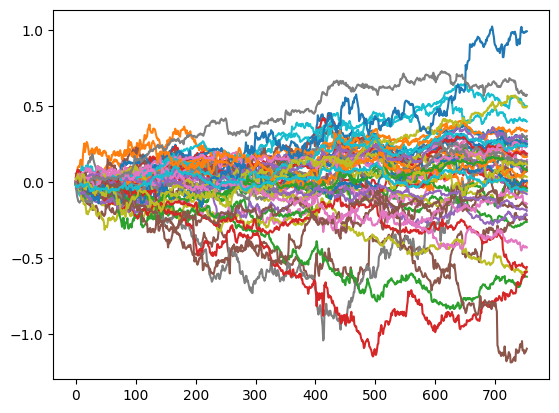

In [31]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

In [32]:
Y_train.head()

date,250,251,252,253,254,255,256,257,258,259,...,744,745,746,747,748,749,750,751,752,753
stocksID,,,,,,,,,,,,,,,,,,,,,
0,0.001128,-0.001046,-0.007027,-0.009757,-0.005868,-0.008563,-0.005857,-0.004588,-0.000240,0.008705,...,-0.012525,-0.011716,0.003532,0.009965,0.018142,-0.001236,-0.002732,0.013074,-0.005843,-0.003823
1,-0.003274,-0.001070,0.000205,0.004862,-0.012834,-0.004868,0.005476,-0.009097,0.000284,0.002971,...,0.014432,-0.002255,-0.011493,0.002291,-0.001346,-0.004026,-0.004672,-0.002889,-0.004984,0.005005
2,-0.003446,-0.001272,0.005824,-0.006994,-0.005512,-0.003652,0.003997,-0.005139,-0.004550,0.001228,...,-0.006245,-0.001329,0.005230,0.003510,0.006022,-0.000343,0.001757,0.004972,0.004916,-0.007338
3,0.001727,0.003143,-0.003606,-0.022219,-0.017467,-0.004536,-0.003512,-0.000156,0.005489,0.005115,...,-0.005179,-0.003442,0.002733,0.013369,0.019738,0.001201,-0.003669,0.008690,0.000272,-0.008150
4,0.004907,0.002472,-0.001487,0.003317,-0.006636,-0.012548,-0.000942,-0.009569,0.004660,-0.018902,...,-0.017507,-0.001233,-0.000552,0.004664,0.005202,0.007695,0.003775,0.005097,0.001135,-0.009262


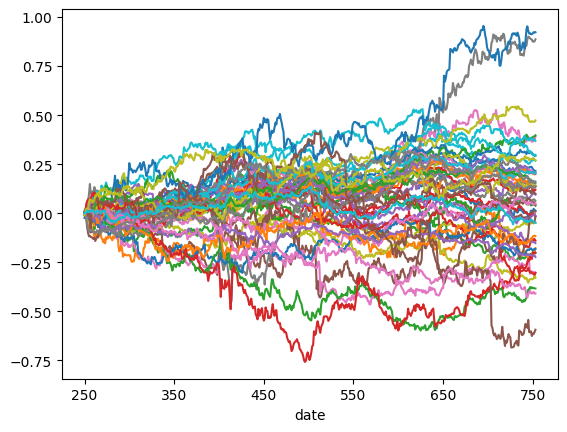

In [33]:
Y_train.T.cumsum().plot(legend=False)
plt.show()

In [59]:
# column : represents a time lag 0 to 250, ie where the time has been shifted to the write from 0 to 250
# we drop raws with Nan Values -> time step begin at 250
# we cut after 753 -> time step finish at 753
# index (time_step, stockID)
X_train_reshape = pd.concat([X_train.T.shift(i+1).stack(future_stack=True) for i in range(250)], axis=1).dropna()
X_train_reshape.columns = pd.Index(range(1, 251), name='timeLag')
X_train_reshape

timeLag            1         2         3         4         5         6    \
    stocksID                                                               
250 0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
    1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
    2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
    3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
    4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   
...                ...       ...       ...       ...       ...       ...   
753 45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
    46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
    47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
    48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
    49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

timeLag            7         8         9         10   ...       241       242  \
    stocksID                                          ...                       
250 0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119 -0.008451   
    1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664 -0.002747   
    2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416  0.001600   
    3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807 -0.010636   
    4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404 -0.005255   
...                ...       ...       ...       ...  ...       ...       ...   
753 45       -0.062300  0.040002 -0.003475 -0.016284  ...  0.003808 -0.003027   
    46        0.006846  0.017514 -0.010796 -0.026356  ... -0.012077 -0.002215   
    47        0.000346 -0.016681  0.008247 -0.002723  ...  0.007291  0.000369   
    48       -0.011879  0.000526  0.003178 -0.010654  ...  0.010960 -0.012003   
    49        0.000633 -0.005819  0.007592 -0.002003  ... -0.024003  0.001416   

timeLag            243       244       245       246       247       248  \
    stocksID                                                               
250 0         0.007120 -0.011745  0.009092 -0.005110 -0.016676 -0.010776   
    1         0.009994 -0.001293  0.012912 -0.004055 -0.006820  0.012173   
    2         0.007640 -0.000637 -0.001353 -0.009522 -0.003425 -0.006044   
    3         0.012446 -0.011980  0.002485 -0.017981 -0.010899 -0.008568   
    4        -0.008182 -0.004614  0.007082  0.007872 -0.003515 -0.007991   
...                ...       ...       ...       ...       ...       ...   
753 45        0.002522 -0.006594 -0.000489  0.054751 -0.012180  0.019142   
    46        0.027569  0.021476  0.003874 -0.001690  0.012346  0.007502   
    47        0.000962 -0.005902  0.001067  0.013055  0.015432  0.023533   
    48       -0.001969  0.030976 -0.000712  0.009795 -0.006842  0.000464   
    49        0.003348 -0.003685 -0.002267 -0.006733  0.000575  0.000735   

timeLag            249       250  
    stocksID                      
250 0        -0.013002 -0.018647  
    1        -0.022280 -0.008254  
    2        -0.013629 -0.008404  
    3        -0.006981 -0.022734  
    4        -0.008315 -0.024546  
...                ...       ...  
753 45       -0.023184 -0.001315  
    46        0.011425 -0.001580  
    47       -0.022811 -0.001053  
    48        0.015894 -0.003321  
    49       -0.020917 -0.004808  

[25200 rows x 250 columns]